<a href="https://colab.research.google.com/github/Kama9031/my-macro-project2/blob/main/python%E3%82%B3%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# --- 1. モデルのパラメータ設定 ---
# 割引因子
BETA = 0.985**20
# 相対的危険回避度
GAMMA = 2.0
# 利子率 (1期間20年)
R = 1.025**20 - 1
# [cite_start]若年期の生産性タイプ [cite: 3]
Y1_TYPES = np.array([0.8027, 1.0, 1.2457])
# [cite_start]中年期の生産性遷移行列 [cite: 5]
P = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])
# 中年期の生産性 (若年期と同じとする)
Y2_TYPES = Y1_TYPES
# [cite_start]資産グリッド (借入はできないため0から) [cite: 3]
A_GRID = np.linspace(0.01, 10, 100)
# [cite_start]所得税率 [cite: 9]
TAX_RATE = 0.30

# --- 効用関数 ---
def utility(c):
    """消費から効用を計算する関数"""
    if GAMMA == 1.0:
        return np.log(c)
    else:
        # 消費が正であることを保証
        c = np.maximum(c, 1e-9)
        return (c**(1 - GAMMA)) / (1 - GAMMA)

In [2]:
# --- 2. 後ろ向き帰納法によるモデル求解 ---

def solve_model(pension_amount):
    """
    年金額を所与として、各期の価値関数と政策関数を解く関数

    Args:
        [cite_start]pension_amount (float): 老年期に受け取る年金額 [cite: 3, 9]

    Returns:
        tuple: 各期の政策関数と価値関数の補間オブジェクト
    """
    # --- 3期 (老年期) ---
    # [cite_start]老年期は全ての資産と年金を消費する [cite: 3]
    c3 = (1 + R) * A_GRID + pension_amount
    v3 = utility(c3)
    v3_interp = interp1d(A_GRID, v3, kind='linear', fill_value="extrapolate")

    # --- 2期 (中年期) ---
    v2_functions = {}
    policy_a2_functions = {}
    for i, y2 in enumerate(Y2_TYPES):
        a2_policy = np.zeros_like(A_GRID)
        v2_values = np.zeros_like(A_GRID)
        # 所得 (税引き後)
        income = y2 * (1 - TAX_RATE if pension_amount > 0 else 1)

        for j, a1 in enumerate(A_GRID):
            # 予算
            budget = (1 + R) * a1 + income
            # 最適化問題: max_{a2} u(c2) + beta * V3(a2)
            res = minimize_scalar(
                lambda a2: -(utility(budget - a2) + BETA * v3_interp(a2)),
                bounds=(0.01, budget - 0.01), # 貯蓄(a2)と消費(c2)が正の範囲
                method='bounded'
            )
            a2_policy[j] = res.x
            v2_values[j] = -res.fun

        v2_functions[i] = interp1d(A_GRID, v2_values, kind='linear', fill_value="extrapolate")
        policy_a2_functions[i] = interp1d(A_GRID, a2_policy, kind='linear', fill_value="extrapolate")

    # --- 1期 (若年期) ---
    v1_functions = {}
    policy_a1_functions = {}
    for i, y1 in enumerate(Y1_TYPES):
        a1_policy = np.zeros_like(A_GRID)
        v1_values = np.zeros_like(A_GRID)

        # [cite_start]期待価値 E[V2(a1)] の計算 [cite: 6]
        expected_v2 = sum(P[i, j] * v2_functions[j](A_GRID) for j in range(len(Y2_TYPES)))
        expected_v2_interp = interp1d(A_GRID, expected_v2, kind='linear', fill_value="extrapolate")

        for j, a0 in enumerate(A_GRID):
            budget = a0 + y1
            res = minimize_scalar(
                lambda a1: -(utility(budget - a1) + BETA * expected_v2_interp(a1)),
                bounds=(0.01, budget - 0.01),
                method='bounded'
            )
            a1_policy[j] = res.x
            v1_values[j] = -res.fun

        v1_functions[i] = interp1d(A_GRID, v1_values, kind='linear', fill_value="extrapolate")
        policy_a1_functions[i] = interp1d(A_GRID, a1_policy, kind='linear', fill_value="extrapolate")

    return policy_a1_functions, policy_a2_functions, v1_functions

--- 問1: 年金がない場合の貯蓄政策関数 ---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21839 (\N{CJK UNIFIED IDEOGRAPH-554F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

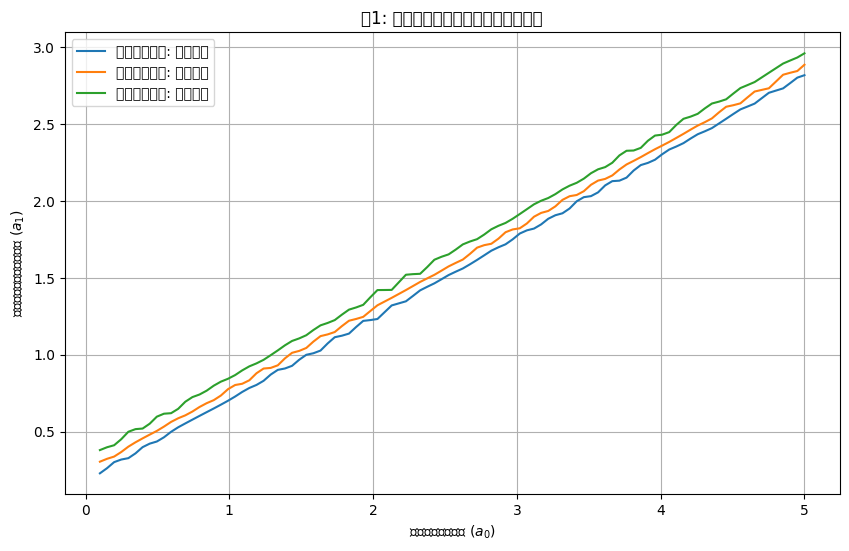

In [3]:
# [cite_start]--- 3. 問1: 年金がない場合の貯蓄政策関数 --- [cite: 8]
print("--- 問1: 年金がない場合の貯蓄政策関数 ---")
policy_a1_no_pension, _, _ = solve_model(pension_amount=0)

plt.figure(figsize=(10, 6))
asset_range = np.linspace(0.1, 5, 100)
for i, y1_type in enumerate(['低生産性', '中生産性', '高生産性']):
    savings = policy_a1_no_pension[i](asset_range)
    plt.plot(asset_range, savings, label=f'若年期生産性: {y1_type}')

plt.xlabel('若年期期初の資産 ($a_0$)')
plt.ylabel('次期（中年期）への貯蓄 ($a_1$)')
plt.title('問1: 年金がない場合の貯蓄の政策関数')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# --- 4. 問2: 一人当たりの年金額の計算 ---
print("\n--- 問2: 一人当たりの年金額の計算 ---")
# 年金がない場合のモデルを再度解く (問1で計算済み)
policy_a1_no_pension, policy_a2_no_pension, _ = solve_model(pension_amount=0)

# シミュレーションのための初期資産分布 (課題で指定がないため仮定)
initial_asset = np.mean(A_GRID)

total_tax_revenue = 0
population_ratio = 1/3 # 各タイプの人口比率

for i in range(len(Y1_TYPES)): # 若年期の生産性タイプ
    # 若年期の貯蓄決定
    a1 = policy_a1_no_pension[i](initial_asset)
    for j in range(len(Y2_TYPES)): # 中年期の生産性タイプ
        # 中年期の所得
        y2 = Y2_TYPES[j]
        # この(i,j)の組み合わせになる人口
        pop = population_ratio * P[i, j]
        # 税収
        tax_revenue = y2 * TAX_RATE * pop
        total_tax_revenue += tax_revenue


--- 問2: 一人当たりの年金額の計算 ---


中年期における政府の総税収: 0.3043
一人当たりの年金額: 0.4986

--- 問3: 年金導入後の貯蓄行動の比較 ---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21839 (\N{CJK UNIFIED IDEOGRAPH-554F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23566 (\N{CJK UNIFIED IDEOGRAPH-5C0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas

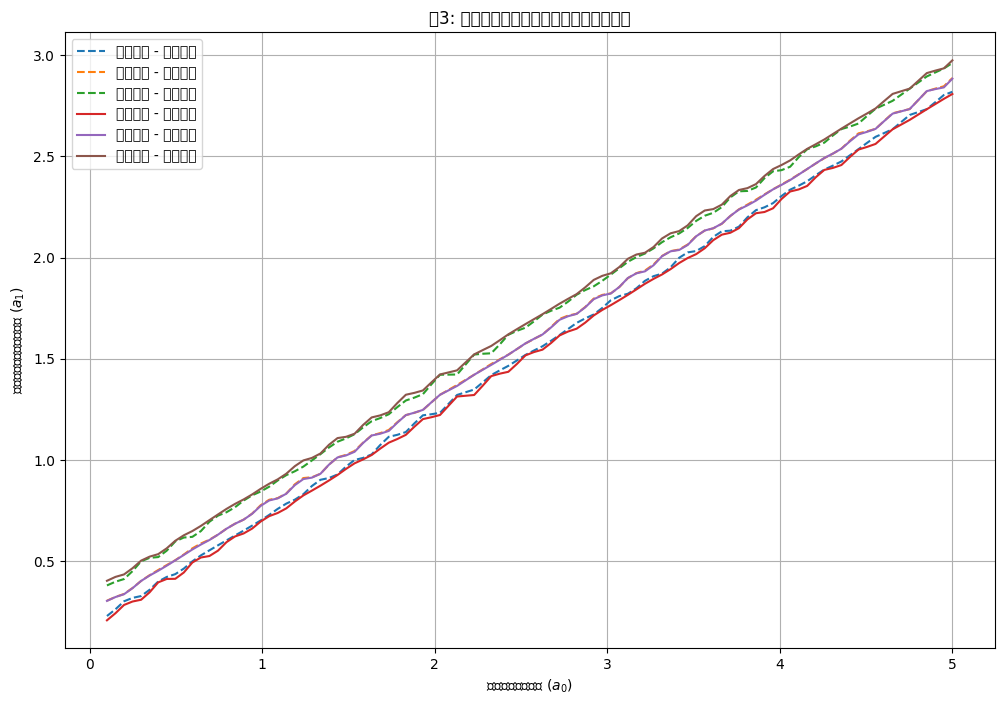


--- 問4: 経済全体の平均期待生涯効用の比較 ---
年金なしの平均期待生涯効用: -2.8251
年金ありの平均期待生涯効用: -2.8083
結論: 年金導入によって経済全体の平均期待生涯効用は増加します。


In [6]:
# [cite_start]政府は税収を利子率で運用 [cite: 9]
total_pension_fund = total_tax_revenue * (1 + R)
# [cite_start]人口は1なので、一人当たりの年金額は総額そのもの [cite: 9]
pension_per_capita = total_pension_fund

print(f"中年期における政府の総税収: {total_tax_revenue:.4f}")
print(f"一人当たりの年金額: {pension_per_capita:.4f}")

# [cite_start]--- 5. 問3: 年金導入後の貯蓄行動の比較 --- [cite: 10]
print("\n--- 問3: 年金導入後の貯蓄行動の比較 ---")
policy_a1_with_pension, _, _ = solve_model(pension_amount=pension_per_capita)

plt.figure(figsize=(12, 8))
# 年金なし
for i, y1_type in enumerate(['低生産性', '中生産性', '高生産性']):
    savings = policy_a1_no_pension[i](asset_range)
    plt.plot(asset_range, savings, linestyle='--', label=f'年金なし - {y1_type}')

# 年金あり
for i, y1_type in enumerate(['低生産性', '中生産性', '高生産性']):
    savings = policy_a1_with_pension[i](asset_range)
    plt.plot(asset_range, savings, linestyle='-', label=f'年金あり - {y1_type}')


plt.xlabel('若年期期初の資産 ($a_0$)')
plt.ylabel('次期（中年期）への貯蓄 ($a_1$)')
plt.title('問3: 年金導入前後の貯蓄の政策関数の比較')
plt.legend()
plt.grid(True)
plt.show()


# [cite_start]--- 6. 問4: 経済全体の平均期待生涯効用の比較 --- [cite: 11]
print("\n--- 問4: 経済全体の平均期待生涯効用の比較 ---")
# [cite_start]若年期の期初資産をゼロとする [cite: 11]
a0 = 0.01 # 厳密なゼロは定義域外なので微小な値

# 年金がない場合の生涯効用
_, _, v1_no_pension = solve_model(pension_amount=0)
utility_no_pension = np.array([v1_no_pension[i](a0) for i in range(len(Y1_TYPES))])
avg_utility_no_pension = np.sum(utility_no_pension * (1/3))

# 年金がある場合の生涯効用
_, _, v1_with_pension = solve_model(pension_amount=pension_per_capita)
utility_with_pension = np.array([v1_with_pension[i](a0) for i in range(len(Y1_TYPES))])
avg_utility_with_pension = np.sum(utility_with_pension * (1/3))


print(f"年金なしの平均期待生涯効用: {avg_utility_no_pension:.4f}")
print(f"年金ありの平均期待生涯効用: {avg_utility_with_pension:.4f}")

if avg_utility_with_pension > avg_utility_no_pension:
    print("結論: 年金導入によって経済全体の平均期待生涯効用は増加します。")
else:
    print("結論: 年金導入によって経済全体の平均期待生涯効用は減少します。")